In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/root/data/"

df_fake = pd.read_csv(data_path + "Fake.csv")
df_true = pd.read_csv(data_path + "True.csv")
df_fake['label'] = 1  # Fake news label
df_true['label'] = 0   # Real news label
df = pd.concat([df_true,df_fake])
df = df.drop(['title','subject','date'],axis=1)

In [31]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


# nltk.download('punkt')
nltk.download('stopwords')
# nltk.download('wordnet')

def load_glove_vectors(glove_file_path):
    word_vectors = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            word_vectors[word] = vector
    return word_vectors

def preprocess_text(text):
    text = text.lower()                              # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)          # Remove special characters and numbers
    tokens = word_tokenize(text)                     # Tokenization
    stop_words = set(stopwords.words('english'))     # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # lemmatizer = WordNetLemmatizer()                 # Lemmatization  ex: running => run (not nesscessary, but i want to test)
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

glove_path = "/root/data/glove/"
word_vectors = load_glove_vectors(glove_path + "glove.6B.100d.txt")


df['clean_text'] = df['text'].apply(preprocess_text)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

def tokens_to_vectors(tokens):
    vectors = []
    for token in tokens:
        if token in word_vectors:
            vectors.append(word_vectors[token])
    if not vectors: # return none if no valid word vectors found 
        return None
    return np.mean(vectors, axis=0)

df['doc_vector'] = df['clean_text'].apply(tokens_to_vectors)
df = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df['doc_vector'].tolist(), df['label'], test_size=0.2, random_state=42)
# df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8343 - loss: 0.4590 - val_accuracy: 0.9018 - val_loss: 0.2371
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8949 - loss: 0.2487 - val_accuracy: 0.9117 - val_loss: 0.2199
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9018 - loss: 0.2394 - val_accuracy: 0.9115 - val_loss: 0.2154
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9020 - loss: 0.2412 - val_accuracy: 0.9165 - val_loss: 0.2123
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9023 - loss: 0.2381 - val_accuracy: 0.9129 - val_loss: 0.2150
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9035 - loss: 0.2351 - val_accuracy: 0.9095 - val_loss: 0.2162
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9013 - loss: 0.2375 - val_accuracy: 0.9149 - val_loss: 0.2109
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9025 - loss: 0.2383 - val_accuracy: 0.9140 - val_

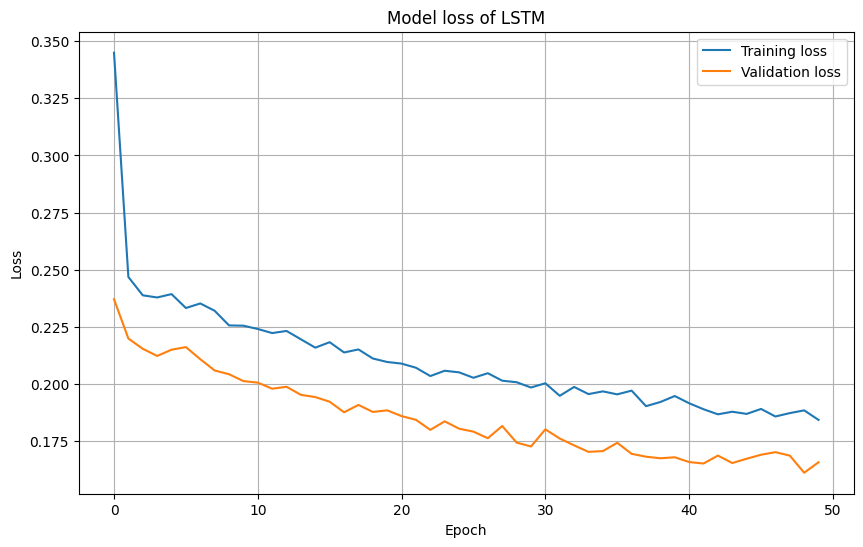

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D

max_len = len(X_train[0])

X_train_reshaped = np.reshape(X_train, (len(X_train), 1, max_len))
X_test_reshaped = np.reshape(X_test, (len(X_test), 1, max_len))

# Define the LSTM model
model0 = Sequential()
model0.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model0.add(Dense(1, activation='sigmoid'))

model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model0.summary())


# Train the model
history = model0.fit(X_train_reshaped, y_train, epochs=50, batch_size=128, validation_split=0.1)
loss, accuracy = model0.evaluate(X_test_reshaped, y_test)
y_pred = model0.predict(X_test_reshaped)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class
y_probs = model0.predict(X_test_reshaped)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss of LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [33]:
import  numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_binary = np.round(y_pred).flatten()
print('----------------')
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred_binary))
print('----------------')
print('Classification report')
print(classification_report(y_test, y_pred_binary))

----------------
Confusion matrix
[[4127  170]
 [ 374 4165]]
----------------
Classification report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4297
           1       0.96      0.92      0.94      4539

    accuracy                           0.94      8836
   macro avg       0.94      0.94      0.94      8836
weighted avg       0.94      0.94      0.94      8836

